In [90]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [91]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten,Dense

In [92]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [93]:
POS_PATH

'data\\positive'

In [94]:
print(os.getcwd())

C:\Users\adity


In [95]:
import uuid

In [96]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
  ret,frame=cap.read()
  frame=frame[120:120+250,200:200+250,:]
  #collecting anchors
  if cv2.waitKey(1) & 0XFF==ord('a'):
      imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
      cv2.imwrite(imgname,frame)
  #collecting positives
  if cv2.waitKey(1) & 0XFF==ord('p'):
      imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
      cv2.imwrite(imgname,frame)
  cv2.imshow('frame',frame)
  if cv2.waitKey(1) & 0XFF==ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

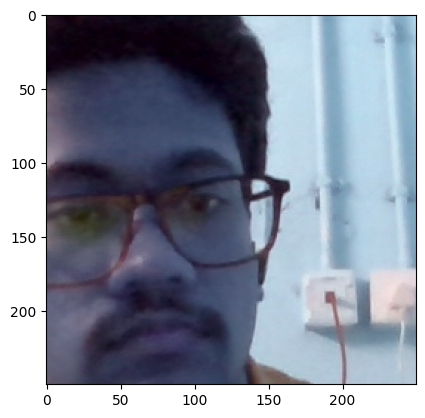

In [141]:
plt.imshow(frame)

In [98]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)


<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\adity\AppData\Local\Temp\ipykernel_26232\1083971521.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
C:\Users\adity\AppData\Local\Temp\ipykernel_26232\1083971521.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
C:\Users\adity\AppData\Local\Temp\ipykernel_26232\1083971521.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)


In [99]:
dir_test=anchor.as_numpy_iterator()

In [100]:
dir_test.next()

b'data\\anchor\\855ce00d-4eb3-11ef-96ad-581cf8dd8906.jpg'

In [101]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    #img=tf.cast(tf.uint8,tf.float32)
    float_img=img/255.0
    return float_img

In [102]:
img=preprocess('data\\anchor\\74fa4a57-4eb3-11ef-8422-581cf8dd8906.jpg')

In [20]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [21]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
samples=data.as_numpy_iterator()

In [19]:
iterator_labs.next()

0.0

In [23]:
samples.next()

(b'data\\anchor\\517dce86-4eb3-11ef-a9c3-581cf8dd8906.jpg',
 b'data\\positive\\87577253-4eb4-11ef-a49b-581cf8dd8906.jpg',
 1.0)

In [24]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [25]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [26]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [27]:
train_samples=train_data.as_numpy_iterator()


In [28]:
train_sample=train_samples.next()

In [29]:
len(train_sample[0])

16

In [30]:
test_data=data.skip(round(len(data)*0.7))
test_data=test_data.take(round(len(data)*0.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [31]:
inp=Input(shape=(100,10,3),name='input_image')

In [32]:
def make_embedding():
    inp=Input(shape=(100,100,3),name='input_image')
    
    #First Block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    
    #Second Block 
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)

    #Third Block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

    #Final embedding block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    
    return Model(inputs=inp,outputs=d1,name='embedding')

In [33]:
    inp=Input(shape=(100,100,3),name='input_image')
    
    #First Block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    
    #Second Block 
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)

    #Third Block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

    #Final embedding block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)

In [34]:
mod=Model(inputs=inp,outputs=d1,name='embedding')

In [35]:
embedding=make_embedding()

In [36]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.reduce_sum(tf.math.abs(input_embedding - validation_embedding),axis=-1)

In [38]:
l1=L1Dist()

In [39]:
l1

<L1Dist name=l1_dist, built=False>

In [40]:
input_image=Input(name='input_img',shape=(100,100,3))
validation_image=Input(name='validation_img', shape=(100,100,3))

In [41]:
inp_embedding=embedding(input_image)
val_embedding=embedding(validation_image)

In [42]:
val_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_19>

In [43]:
siamese_layer=L1Dist()

In [44]:
siamese_layer((inp_embedding,val_embedding))

<KerasTensor shape=(None,), dtype=float32, sparse=False, name=keras_tensor_20>

In [45]:
class ExpandDims(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDims, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)


In [46]:
def make_siamese_model():
    
    #anchor and validation images
    input_image=Input(name='input_img',shape=(100,100,3))
    validation_image=Input(name='validation_img', shape=(100,100,3))

    inp_embedding=embedding(input_image)
    val_embedding=embedding(validation_image)
    #combine siamese distance components
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    expand_layer = ExpandDims(axis=-1, name='expand_dims')
    distances=siamese_layer((inp_embedding,val_embedding))
    distances_expanded = expand_layer(distances)

    #classification layer
    classifier=Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [47]:
siamese_layer._name='distance'
expand_layer = ExpandDims(axis=-1, name='expand_dims')
distances=siamese_layer((inp_embedding,val_embedding))
distances_expanded = expand_layer(distances)
#distances_expanded = tf.expand_dims(distances, axis=-1)


In [48]:
classifier=Dense(1,activation='sigmoid')(distances_expanded)

In [49]:
siamese_model=Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None)                    │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expand_dims (ExpandDims)      │ (None, 1)                 │               0 │ l1_dist_1[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │               2 │ expand_dims[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,960,450 (148.62 MB)

 Trainable params: 38,960,450 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:
X = batch_1[:2]

In [57]:
y = batch_1[2]

In [58]:
y

array([1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [59]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [60]:
from tensorflow.keras.metrics import Precision, Recall

In [61]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [62]:
EPOCHS = 50

In [63]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step

In [64]:
from tensorflow.keras.metrics import Precision,Recall

In [159]:
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

In [160]:
y_hat=siamese_model.predict([test_input,test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


array([[0.99970955],
       [0.99950767],
       [0.47496077],
       [0.4708319 ],
       [0.9999446 ],
       [0.4707635 ],
       [0.47227567],
       [0.99988174],
       [0.47002688],
       [0.99983454],
       [0.47030511],
       [0.4721715 ],
       [0.47008747],
       [0.4714692 ],
       [0.99971247],
       [0.4746632 ]], dtype=float32)

In [161]:
[1 if prediction>0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]

In [162]:
y_true

array([1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [163]:
m=Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [164]:
m=Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

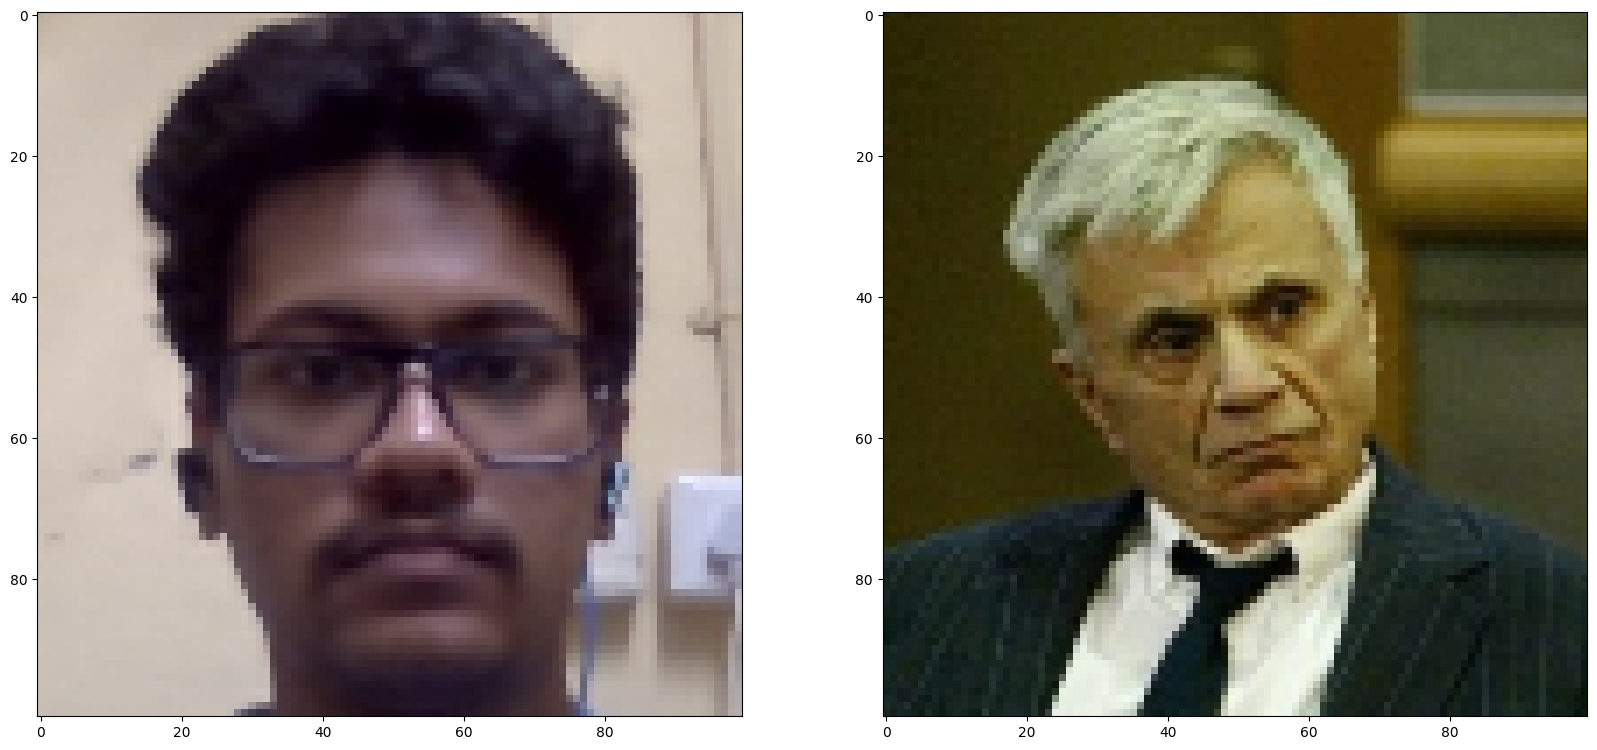

In [165]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_input[10])
plt.subplot(1,2,2)
plt.imshow(test_val[10])
plt.show()

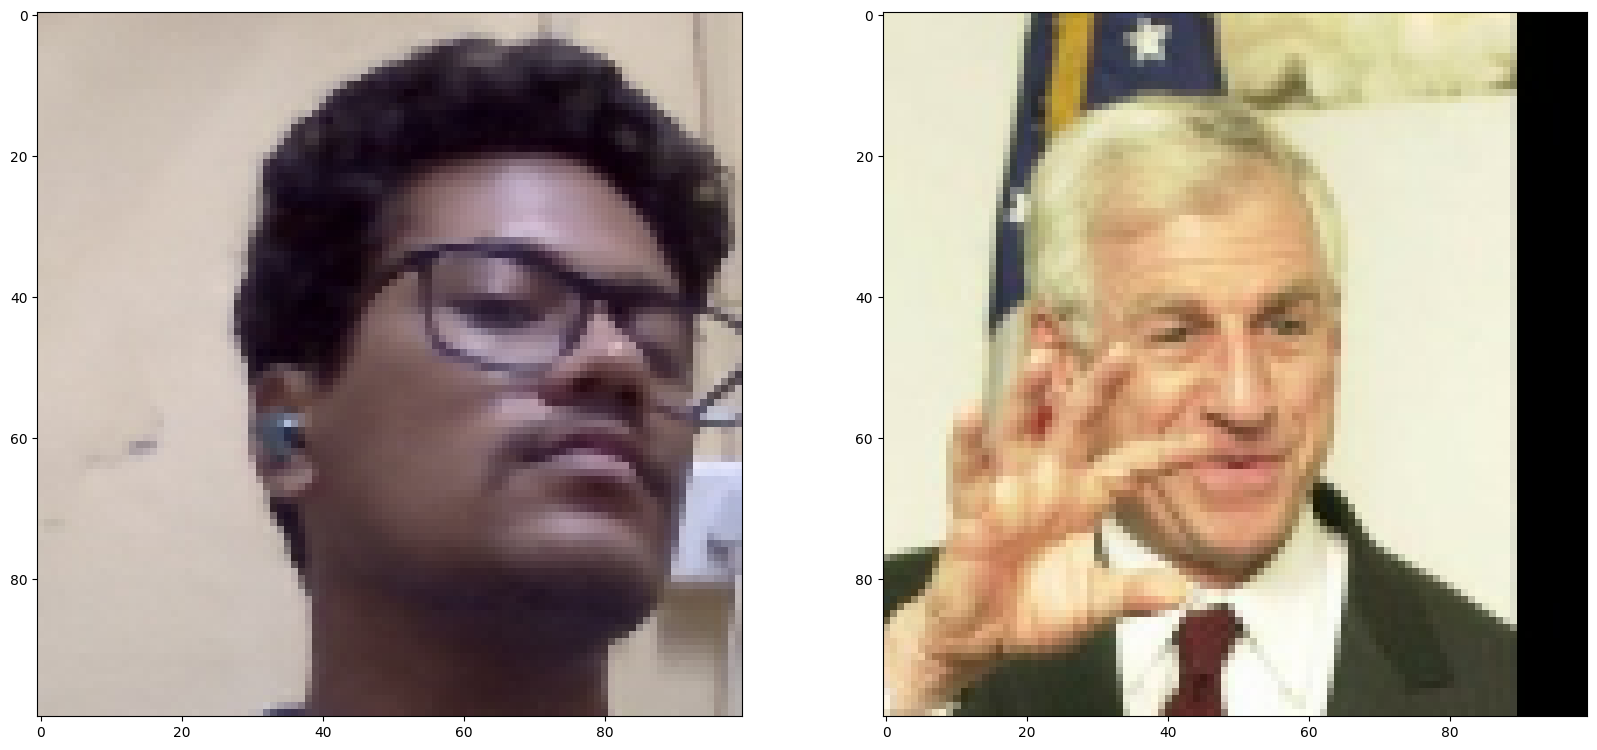

In [169]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])
plt.show()

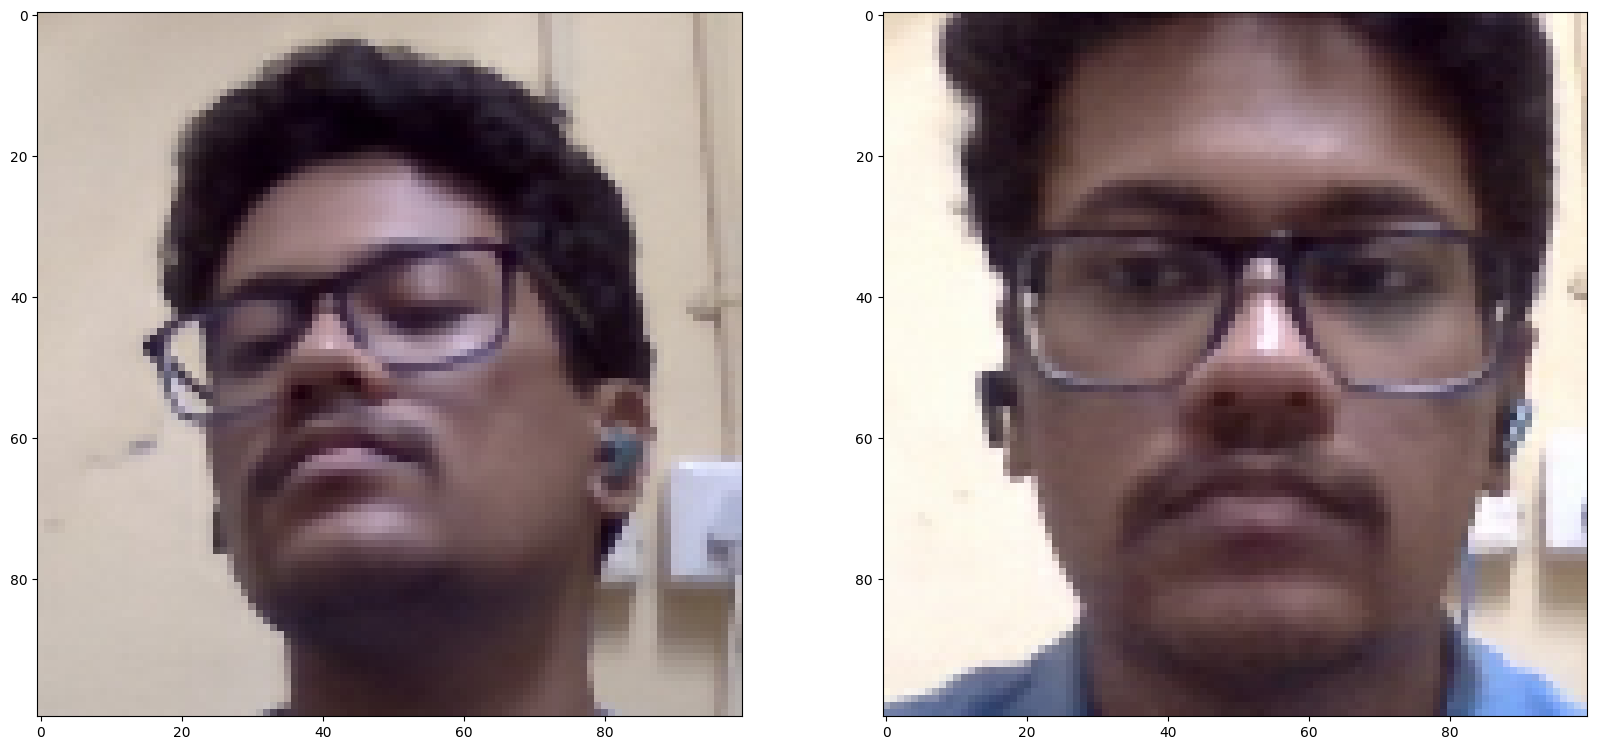

In [172]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_input[7])
plt.subplot(1,2,2)
plt.imshow(test_val[7])
plt.show()

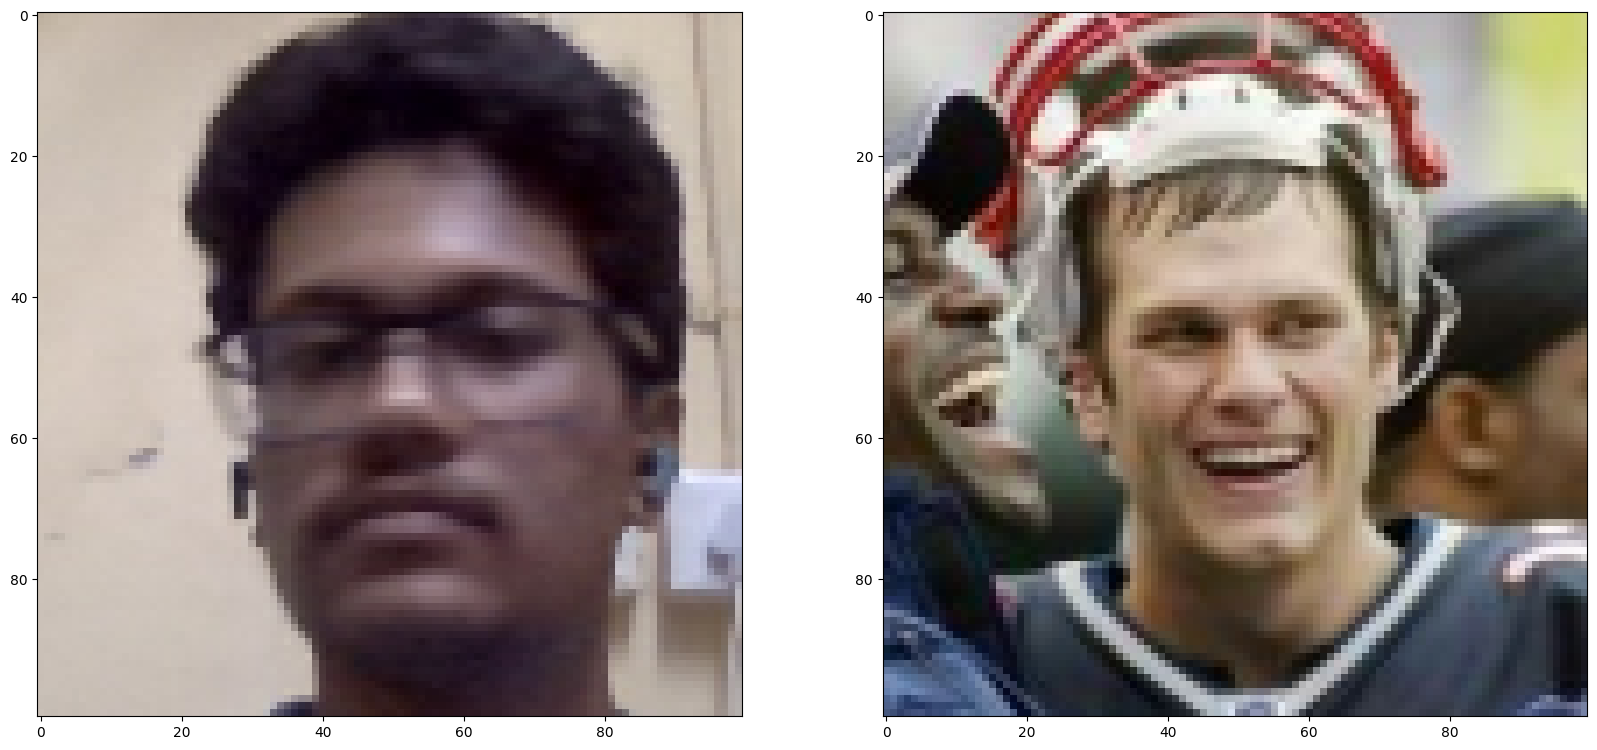

In [174]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_input[-1])
plt.subplot(1,2,2)
plt.imshow(test_val[])
plt.show()

In [72]:
siamese_model.save('siamesemodel.h5')

In [73]:
#model=tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# REAL TIME VERIFICATION ##

## Did a significant part of real time verification but couldn't upload a video. Don't evaluate this part as it needs some minute changes to shoot up the accuracy 

In [74]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\2a48a3cc-4eb4-11ef-99fb-581cf8dd8906.jpg
application_data\verification_images\2a70aa39-4eb4-11ef-9738-581cf8dd8906.jpg
application_data\verification_images\2a944ded-4eb4-11ef-8ac9-581cf8dd8906.jpg
application_data\verification_images\2abc5bf4-4eb4-11ef-b137-581cf8dd8906.jpg
application_data\verification_images\2adae4a5-4eb4-11ef-981f-581cf8dd8906.jpg
application_data\verification_images\2b0313ab-4eb4-11ef-b025-581cf8dd8906.jpg
application_data\verification_images\2b304881-4eb4-11ef-a233-581cf8dd8906.jpg
application_data\verification_images\2b53bad3-4eb4-11ef-8613-581cf8dd8906.jpg
application_data\verification_images\2b80db4e-4eb4-11ef-8dff-581cf8dd8906.jpg
application_data\verification_images\2bae50d8-4eb4-11ef-9982-581cf8dd8906.jpg
application_data\verification_images\2c03f125-4eb4-11ef-be89-581cf8dd8906.jpg
application_data\verification_images\2c121689-4eb4-11ef-8bf8-581cf8dd8906.jpg
application_data\verification_images\2c2c3952-4eb4-11ef-a68e-581

In [75]:
def verify(model, detection_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV Real Time Verification

In [158]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9998, 0.49)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [156]:
np.sum(np.squeeze(results) > 0.9998)

25

In [148]:
results

[array([[0.99978477]], dtype=float32),
 array([[0.9997562]], dtype=float32),
 array([[0.99939096]], dtype=float32),
 array([[0.99970084]], dtype=float32),
 array([[0.99958026]], dtype=float32),
 array([[0.99986035]], dtype=float32),
 array([[0.9999019]], dtype=float32),
 array([[0.99992514]], dtype=float32),
 array([[0.9656751]], dtype=float32),
 array([[0.9974059]], dtype=float32),
 array([[0.9966231]], dtype=float32),
 array([[0.99775285]], dtype=float32),
 array([[0.9993123]], dtype=float32),
 array([[0.9997373]], dtype=float32),
 array([[0.9996701]], dtype=float32),
 array([[0.9970209]], dtype=float32),
 array([[0.9999171]], dtype=float32),
 array([[0.99788785]], dtype=float32),
 array([[0.99968517]], dtype=float32),
 array([[0.9997741]], dtype=float32),
 array([[0.99944156]], dtype=float32),
 array([[0.9992267]], dtype=float32),
 array([[0.99879754]], dtype=float32),
 array([[0.9986311]], dtype=float32),
 array([[0.9996032]], dtype=float32),
 array([[0.999403]], dtype=float32),
 a